# Mediationsprototype 2.3 
 Version 2 Teil 3 Analyse der Transkripte 



anonymizierte Transkripte Fall 5 mit 6 Sitzungen und Fall 8 mit 5 Sitzungen befinden sich in /anon 
F8_1.txt ist Fall 8 Sitzung 1 usw.  


Dieser Prototyp hat zum Ziel die vorhandenen Transkriptionen zu Analysieren und zu visualisieren: 
- Redeanteile
- Sentiments über den Zeiterlauf 
    - je Sprecher 
    - über jede Sitzung
    - pro Fall
    - Erkennen von extremen Stimmungswechseln
- Rederichtungen
- 





## Vorbereitungen 

In [2]:
#imports und Basiskonfiguration
import os
import re


#Festlegen des Analysefalls
#Fall = "F5"
Fall = "F8"
input_dir = fr"anon\{Fall}"
dateien = os.listdir(input_dir)

In [3]:
# Laden der Texte
# laden der Transkripte
text_dict = {}
for datei in dateien:  
    print(f"Transkript : {datei} geladen")
    with open(os.path.join(input_dir, datei), 'r', encoding='utf-8') as file:
        Sitzungen = file.read()
        text_dict[datei] = Sitzungen


Transkript : F8_1.txt geladen
Transkript : F8_2.txt geladen
Transkript : F8_3.txt geladen
Transkript : F8_4.txt geladen
Transkript : F8_5.txt geladen


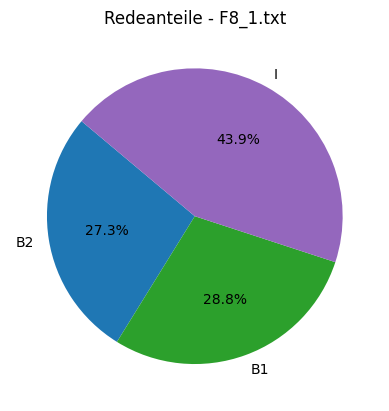

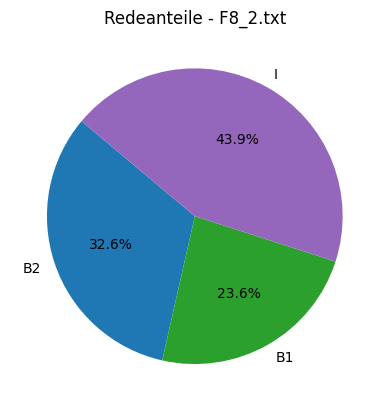

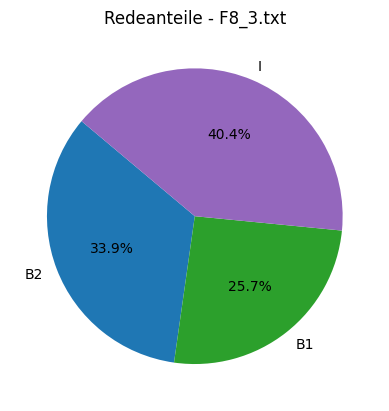

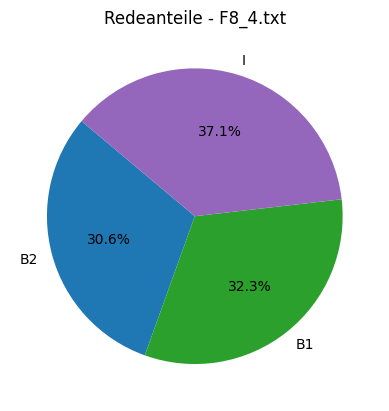

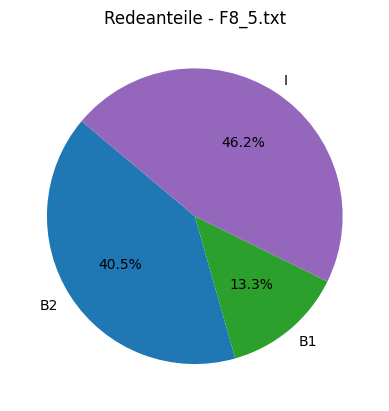

In [4]:
import re
import matplotlib.pyplot as plt
import numpy as np
import os
from docx import Document
from docx.shared import Inches

# Muster für die Extraktion von Sprecher und Zeit
pattern = r'^(\w+):.*?#(\d{2}):(\d{2}):(\d{2})-(\d{1,2})#$'

# Eindeutige Sprecher sammeln
speakers = set()

# Session Sepakers time
session_speaker_times = {}

for filename, text in text_dict.items():
    unique_speakers = set()
    
    # Extrahiere und speichere Sprecher aus dem Text
    for match in re.finditer(pattern, text, re.MULTILINE):
        speaker, _, _, _, _ = match.groups()
        unique_speakers.add(speaker)
    
    speakers.update(unique_speakers)

# Farbpalette für Sprecher definieren
colors = plt.cm.tab10(np.linspace(0, 1, len(speakers)))

# Create a new Word document
doc = Document()

# Loop über die Sitzungen
for filename, text in text_dict.items():
    speech_times = {speaker: 0 for speaker in speakers}
    
    # Extrahiere Zeitdaten und berechne Gesamtzeit pro Sprecher
    for match in re.finditer(pattern, text, re.MULTILINE):
        speaker, hours, minutes, seconds, duration = match.groups()
        total_seconds = int(hours) * 3600 + int(minutes) * 60 + int(seconds)
        speech_times[speaker] += total_seconds

    session_speaker_times[filename] = speech_times    
    total_time = sum(speech_times.values())
    speech_percent = {speaker: time / total_time * 100 for speaker, time in speech_times.items()}
    
    # Schwellenwert-Filterung anwenden
    threshold = 0.5  # In Prozent
    filtered_speech_percent = {speaker: percent for speaker, percent in speech_percent.items() if percent >= threshold}
    
    # Erstelle Tortendiagramm für diese Sitzung
    fig, ax = plt.subplots()
    labels = list(filtered_speech_percent.keys())
    sizes = list(filtered_speech_percent.values())
    #labels_percent = [f'{label}\n({sizes[i]:.1f}%)' for i, label in enumerate(labels)]
     
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    ax.set_title(f'Redeanteile - {filename}')
    plot_filename = f"{filename}.png"
    plt.savefig(plot_filename)
    # Insert the saved plot image into the Word document
    doc.add_picture(plot_filename, width=Inches(6))  # Adjust the width as needed
    
    # Add a caption or any additional information if required
    #doc.add_paragraph(f"Redeanteile für {filename}")
    
    # Remove the temporary plot image file
    os.remove(plot_filename)


Gesamtlänge in Zeichen: 0
Gesamtlänge in Zeit: 0 Stunden, 0 Minuten, 0 Sekunden


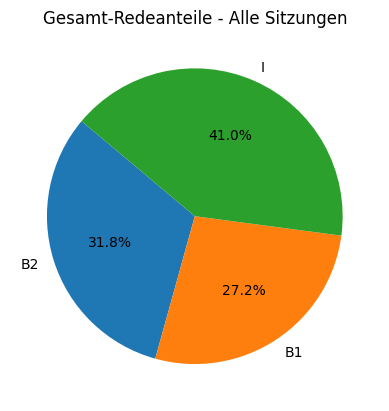

In [9]:
# Gesammelte Redezeit pro Sprecher
all_speakers_times = {speaker: 0 for speaker in speakers}

# Gesamtlänge in Zeichen und Zeit
total_characters = 0
total_seconds = 0


# Werte aus allen Sitzungen zusammenführen
for session_name, speaker_times in session_speaker_times.items():  
    for speaker, time in speaker_times.items():
        all_speakers_times[speaker] += time

# Filterung nach Schwellenwert (z.B. 0.5%)
threshold = 1
filtered_speaker_times = {speaker: time for speaker, time in all_speakers_times.items() if time / sum(all_speakers_times.values()) * 100 >= threshold}

# Tortendiagramm für alle Sitzungen
fig, ax = plt.subplots()
labels = list(filtered_speaker_times.keys())
sizes = list(filtered_speaker_times.values())
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
ax.set_title('Gesamt-Redeanteile - Alle Sitzungen')
#plt.show()

plot_filename = f"{Fall}.png"
plt.savefig(plot_filename)

# Insert the saved plot image into the Word document
doc.add_picture(plot_filename, width=Inches(6))  # Adjust the width as needed
# Add a caption or any additional information if required
#doc.add_paragraph(f"Redeanteile für {plot_filename}")
    
# Remove the temporary plot image file
os.remove(plot_filename)

# Gesamtlänge in Zeichen und Zeit in das Dokument einfügen
total_hours = total_seconds // 3600
total_minutes = (total_seconds % 3600) // 60
total_seconds = total_seconds % 60

print(f"Gesamtlänge in Zeichen: {total_characters}")
print(f"Gesamtlänge in Zeit: {total_hours} Stunden, {total_minutes} Minuten, {total_seconds} Sekunden")
doc.add_paragraph(f"Gesamtlänge in Zeichen: {total_characters}")
doc.add_paragraph(f"Gesamtlänge in Zeit: {total_hours} Stunden, {total_minutes} Minuten, {total_seconds} Sekunden")


# Save the Word document
doc.save(f"Ergebnisse\\{Fall}\\{Fall}_Redeanteile.docx")

## Sentiments im Zeitverlauf


In [38]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from textblob import TextBlob
from transformers import pipeline

def perform_sentiment_analysis_Polarity(text):
    blob = TextBlob(text)
    sentiment_score = blob.sentiment.polarity
    return sentiment_score

# Wähle ein spezifisches Modell für die Sentiment-Analyse aus
pipeline_model_name = "lxyuan/distilbert-base-multilingual-cased-sentiments-student"  # Beispielmodell, du kannst ein passendes Modell wählen
pipeline_classifier = pipeline("sentiment-analysis", model=pipeline_model_name, return_all_scores=True, max_length=512)

def perform_sentiment_analysis_pipline(text):
    # Führe die Sentiment-Analyse mit dem ausgewählten Transformer-Modell durch
    sentiment_results = pipeline_classifier(text)
    # Dictionary zum Zuweisen der Werte zu den Labels 
    label_values = {'positive': 1, 'negative': -1, 'neutral': 0}
    # Gewichtete Summe der Scores für Positive und Negative Labels
    weighted_sum = sum(sentiment_result['score'] * label_values.get(sentiment_result['label'].lower(), 0) for sentiment_result in sentiment_results[0])
    return weighted_sum
    


# Laden des RoBERTa-Tokenizer
roBERTa_tokenizer = RobertaTokenizer.from_pretrained('SamLowe/roberta-base-go_emotions')
# Laden des vortrainierten RoBERTa-Modells für Sentimentanalyse
roBERTa_model = RobertaForSequenceClassification.from_pretrained('SamLowe/roberta-base-go_emotions')

def perform_sentiment_analysis_roBERTa(text):
  
    # Tokenisierung des Texts
    inputs = roBERTa_tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    # Sentimentanalyse durchführen
    outputs = roBERTa_model(**inputs)
    # Extrahiere die Polarity-Werte aus den Ausgaben
    polarity_values = outputs.logits.squeeze().tolist()
    # Der Wert bei Index 0 entspricht der Polarity für die negative Klasse,
    # der Wert bei Index 1 entspricht der Polarity für die positive Klasse.
    polarity = polarity_values[1] - polarity_values[0]
    # Normalisiere die Polarity-Werte
    total_polarity = polarity / (abs(polarity_values[0]) + abs(polarity_values[1]))
    return total_polarity



# Laden des BERT-Tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('mdraw/german-news-sentiment-bert')
# Laden des vortrainierten BERT-Modells für Sentimentanalyse
bert_model = BertForSequenceClassification.from_pretrained('mdraw/german-news-sentiment-bert')

def perform_sentiment_analysis_with_BERT(text):
     # Tokenisierung des Texts
    inputs = bert_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)

    # Sentimentanalyse durchführen
    outputs = bert_model(**inputs)

    # Extrahiere die Polarity-Werte aus den Ausgaben
    logits = outputs.logits
    polarity_values = torch.softmax(logits, dim=1).tolist()[0]

    # Der Wert bei Index 0 entspricht der Polarity für die negative Klasse,
    # der Wert bei Index 1 entspricht der Polarity für die positive Klasse.
    positive_polarity = polarity_values[1]
    negative_polarity = polarity_values[0]

    # Berechne die Gesamtpolarität
    polarity = positive_polarity - negative_polarity
    # Normalisiere die Polarity-Werte
    total_polarity = polarity / (abs(polarity_values[0]) + abs(polarity_values[1]))

    return total_polarity



In [39]:

from openai import OpenAI
import re

def extract_float(data):
    pattern = r"\d+\.\d+"  # Muster für eine Zahl mit Dezimalpunkt
    match = re.search(pattern, data)
    if match:
        return float(match.group())  
    else:
        return None


# Point to the local server
client = OpenAI(base_url="http://k3:1234/v1", api_key="not-needed")


def perform_sentiment_analysis_with_k3(text):
  completion = client.chat.completions.create(
    model="local-model", # this field is currently unused
    messages=[
      {"role": "system", "content": "Antworte nur mit dem Ergebnis als Float zwischen -1 and 1. Bitte lasse alle jeden Text weg."},
      {"role": "user", "content": f"Gib mir die Sentimentbewertung im Intervall -1 und 1, wobei -1 sehr negativ, 1 sehr positiv und 0 neutral bedeutet für den Text: {text}" }
    ],
    temperature=0.3,
  )
  return(extract_float(completion.choices[0].message.content))

## Ausführen der Sentimentsanalysen im Vergleich
Die Analysen werden xls gespeichert im verzeichniss /sentiments/Session

In [40]:
import pandas as pd
import re
from transformers import pipeline

# Muster für die Extraktion von Informationen
pattern = r'^(.*?): (.*) #(\d{2}:\d{2}:\d{2}-\d{1,2})#$'

for filename, text in text_dict.items():
    # Definiere die Spalten für die Tabelle
    columns = ["Zeilennummer", "Sprecher", "Zeitstempel", "Text", "Sentiment_Polarity","Sentiment_Pipeline","Sentiment_BERT","Sentiment_roBERTa","sentiment_score_llama3"]
    data = []
    # Extrahiere Informationen für jede Zeile
    for i, line in enumerate(text.strip().split('\n'), 1):
        match = re.match(pattern, line)
        if match:
            speaker, text, timestamp = match.groups()
            #Sentiments
            sentiment_score_Polarity = perform_sentiment_analysis_Polarity(text)
            sentiment_score_Pipeline = perform_sentiment_analysis_pipline(text)
            sentiment_score_BERT = perform_sentiment_analysis_with_BERT(text)
            sentiment_score_roBERTa = perform_sentiment_analysis_roBERTa(text)
            #sentiment_score_k3 = 0
            sentiment_score_k3 = perform_sentiment_analysis_with_k3(text)
            data.append([i, speaker, timestamp, text, sentiment_score_Polarity,sentiment_score_Pipeline,sentiment_score_BERT,sentiment_score_roBERTa,sentiment_score_k3])
    # Erstelle DataFrame und zeige die Tabelle
    df = pd.DataFrame(data, columns=columns)
    # Excel-Datei erstellen und Daten speichern
    excel_file = f"Ergebnisse\\{Fall}\\Sentiments\\{filename}_Sentiments.xlsx"
    df.to_excel(excel_file, index=False)
    print("Daten wurden erfolgreich in '{}' gespeichert.".format(excel_file))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Daten wurden erfolgreich in 'Ergebnisse\F5\Sentiments\F5_1.txt_Sentiments.xlsx' gespeichert.
Daten wurden erfolgreich in 'Ergebnisse\F5\Sentiments\F5_2.txt_Sentiments.xlsx' gespeichert.
Daten wurden erfolgreich in 'Ergebnisse\F5\Sentiments\F5_3.txt_Sentiments.xlsx' gespeichert.
Daten wurden erfolgreich in 'Ergebnisse\F5\Sentiments\F5_4.txt_Sentiments.xlsx' gespeichert.
Daten wurden erfolgreich in 'Ergebnisse\F5\Sentiments\F5_5.txt_Sentiments.xlsx' gespeichert.
Daten wurden erfolgreich in 'Ergebnisse\F5\Sentiments\F5_6.txt_Sentiments.xlsx' gespeichert.
